<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE40455-2020](https://jckantor.github.io/CBE40455-2020);
content is available [on Github](https://github.com/jckantor/CBE40455-2020.git).*


<!--NAVIGATION-->
< [2.0 Modeling](https://jckantor.github.io/CBE40455-2020/02.00-Modeling.html) | [Contents](toc.html) | [2.2 Campus SEIR Modeling](https://jckantor.github.io/CBE40455-2020/02.02-Campus-SEIR-modeling.html) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/02.01-Campus-SIR-modeling.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/02.01-Campus-SIR-modeling.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 2.1 Campus SIR Modeling



## 2.1.1 Campus infection data

The following data consists of new infections reported since August 3, 2020, from diagnostic testing administered by the Wellness Center and University Health Services at the University of Notre Dame. The data is publically available on the [Notre Dame Covid-19 Dashboard](https://here.nd.edu/our-approach/dashboard/).

/Users/jeff/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


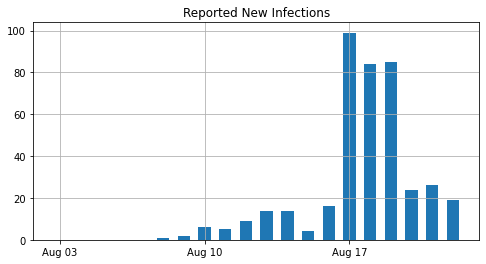

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from datetime import timedelta

data = [
    ["2020-08-03", 0],
    ["2020-08-04", 0],
    ["2020-08-05", 0],
    ["2020-08-06", 0],
    ["2020-08-07", 0],
    ["2020-08-08", 1],
    ["2020-08-09", 2],
    ["2020-08-10", 6],
    ["2020-08-11", 5],
    ["2020-08-12", 9],
    ["2020-08-13", 14],
    ["2020-08-14", 14],
    ["2020-08-15", 4],
    ["2020-08-16", 16],
    ["2020-08-17", 99],
    ["2020-08-18", 84],
    ["2020-08-19", 85],
    ["2020-08-20", 24],
    ["2020-08-21", 26],
    ["2020-08-22", 19],
]

df = pd.DataFrame(data, columns=["date", "new cases"])
df["date"] = pd.to_datetime(df["date"])

fig, ax = plt.subplots(figsize=(8,4))
ax.bar(df["date"], df["new cases"], width=0.6)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.title("Reported New Infections")
plt.grid()

## 2.1.2 Fitting an SIR model to campus data

Because of  the limited amount of data available at the time this notebook was prepared, the model fitting has been limited to a standard SIR model for infectious disease in a homogeneous population.

$$\text{Susceptible}
\xrightarrow {\frac{\beta S I}{N}} 
\text{Infectious} 
\xrightarrow{\gamma I} 
\text{Recovered} $$

The resulting differential equations are:

$$\begin{align*}
\frac{dS}{dt} &= -\beta S \frac{I}{N} \\
\frac{dI}{dt} &= \beta S \frac{I}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I \\
\end{align*}$$

The recovery rate is given by $\gamma = 1/t_{recovery}$ where the average recovery time $t_{recovery}$ is estimated as 8 days. 


| Parameter | Description | Estimated Value | Source |
| :-- | :-- | :-- | :-- |
| $N$ | campus population | 15,000 | estimate |
| $\gamma$ | average recovery rate | 1/8.0 $d^{-1}$ | literature |
| $\beta$ | infection rate constant | tbd | fitted to data | 
| $I_0$ | initial infectives on Aug 3, 2020 | tbd | fitted to data 
| $R_0$ | reproduction number | tbd | calculated as ${\beta}/{\gamma}$

R0 = 2.0


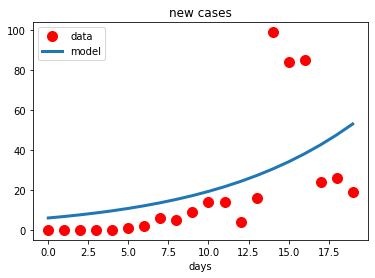

In [2]:
N = 15000         # estimated campus population
gamma = 1/8.0     # recovery rate = 1 / average recovery time in days

def model(t, y, beta):
    S, I, R = y
    dSdt = -beta*S*I/N
    dRdt = gamma*I
    dIdt = -dSdt - dRdt
    return np.array([dSdt, dIdt, dRdt])

def solve_model(t, params):
    beta, I_initial = params
    IC = [N - I_initial, I_initial, 0.0]
    soln = solve_ivp(lambda t, y: model(t, y, beta), np.array([t[0], t[-1]]), 
                IC, t_eval=t, atol=1e-6, rtol=1e-9)
    S, I, R = soln.y
    U = beta*S*I/N
    return S, I, R, U

def residuals(df, params):
    S, I, R, U = solve_model(df.index, params)
    return np.linalg.norm(df["new cases"] - U)

def fit_model(df, params_est=[0.5, 0.5]):
    return minimize(lambda params: residuals(df, params), params_est, method="Nelder-Mead").x

def plot_data(df):
    plt.plot(df.index, np.array(df["new cases"]), "r.", ms=20, label="data")
    plt.xlabel("days")
    plt.title("new cases")
    plt.legend()

def plot_model(t, params):
    print("R0 =", round(beta/gamma, 1))
    S, I, R, U = solve_model(t, params)
    plt.plot(t, U, lw=3, label="model")
    plt.xlabel("days")
    plt.title("new cases")
    plt.legend()

plot_data(df)
beta, I_initial = fit_model(df)
plot_model(df.index, [beta, I_initial])

## 2.1.3 Fitted parameter values

In [3]:
from tabulate import tabulate
parameter_table = [
                   ["N", 15000],
                   ["I0", I_initial],
                   ["beta", beta],
                   ["gamma", gamma],
                   ["R0", beta/gamma]
]
print(tabulate(parameter_table, headers=["Parameter", "Value"]))

Parameter           Value
-----------  ------------
N            15000
I0              24.5549
beta             0.244001
gamma            0.125
R0               1.95201


## 2.1.4 Short term predictions of newly confirmed cases

Using the fitted parameters, the following code presents a short term projection of newly diagnosed infections. Roughly speaking, the model projects a 50% increase per day in newly diagnosed cases as a result of testing sympotomatic individuals. 

The number of infected but asympotomatic individuals is unknown at this time, but can be expected to be a 2x multiple of this projection.

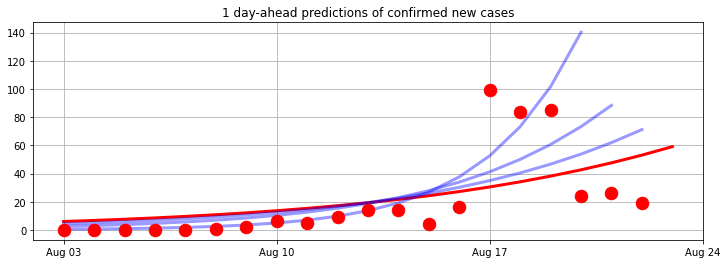

In [4]:
# prediction horizon (days ahead)
H = 1

# retrospective lag
K = 3

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
for k in range(0, K+1):
    # use data up to k days ago
    if k > 0:
        beta, I_initial = fit_model(df[:-k])
        P = max(df[:-k].index) + H
        c = 'b'
        a = 0.4
    else:
        beta, I_initial = fit_model(df)
        P = max(df.index) + H
        c = 'r'
        a = 1.0

    # simulation
    t = np.linspace(0, P, P+1)
    S, I, R, U  = solve_model(t, [beta, I_initial])

    # plotting
    dates = [df["date"][0] + timedelta(days=t) for t in t]
    ax.plot(dates, U, c, lw=3, alpha=a)

ax.plot(df["date"], df["new cases"], "r.", ms=25, label="new infections (data)")
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.grid(True)
ax.set_title(f"{H} day-ahead predictions of confirmed new cases");

### 2.1.4.1 Simple logarithmic extrapolation

[0.2009787  0.24331935]


Text(0.5, 1.0, 'New cases')

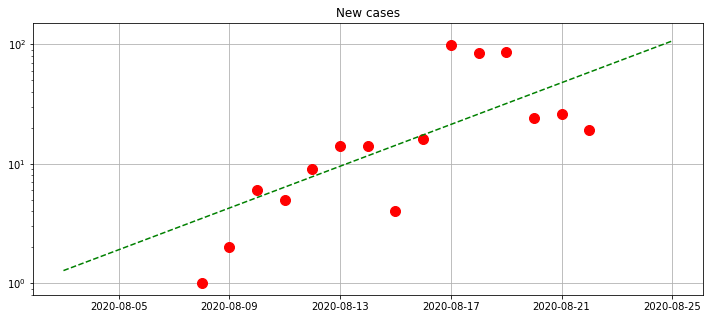

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.semilogy(df["date"], df["new cases"], "r.", ms=20)

t_fit = np.array(df[6:].index)
y_fit = np.log(np.array(df[6:]["new cases"]))
p = np.polyfit(t_fit, y_fit, 1)

t = np.linspace(min(df.index), max(t_fit) + 3)
y = np.exp(p[0]*t + p[1])
dates = [df["date"][0] + timedelta(days=t) for t in t]

print(p)
ax.semilogy(dates, y, 'g--')
ax.grid(True)
ax.set_ylim(0.8, 150)
ax.set_title('New cases')

In [6]:
np.exp(p[0]) - 1.0

0.22259873535947472

<!--NAVIGATION-->
< [2.0 Modeling](https://jckantor.github.io/CBE40455-2020/02.00-Modeling.html) | [Contents](toc.html) | [2.2 Campus SEIR Modeling](https://jckantor.github.io/CBE40455-2020/02.02-Campus-SEIR-modeling.html) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455-2020/blob/master/docs/02.01-Campus-SIR-modeling.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/CBE40455-2020/02.01-Campus-SIR-modeling.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>